In [1]:
#import sys
#!python -m pip install --upgrade ..

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path

# External
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import RocCurveDisplay, auc, accuracy_score, auc

# Local
from adad.evaluate import (cumulative_accuracy, permutation_auc,
                           predictiveness_curves, roc_ad,
                           sensitivity_specificity)
from adad.bounding_box import PCABoundingBox
from adad.utils import  maccs2binary

In [4]:
SEED = np.random.randint(1000, 999999)
print(f'The seed is {SEED}')

The seed is 722798


In [5]:
# Step 1: Load data
PATH_ROOT = Path(os.getcwd()).absolute().parent
print(PATH_ROOT)

file_data = os.path.join(PATH_ROOT, "data", "maccs", "Ames_MACCS.csv")
file_idx_train = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_train.csv")
file_idx_test = os.path.join(PATH_ROOT, "data", "cv", "Ames_cv_test.csv")

C:\Users\sarah\Desktop\applicabilityDomain


In [6]:
idx_train = pd.read_csv(file_idx_train, dtype=pd.Int64Dtype())
idx_test = pd.read_csv(file_idx_test, dtype=pd.Int64Dtype())

In [7]:
data = pd.read_csv(file_data)
data["y"] = data["y"].astype("category").cat.codes
print("Labels:", data["y"].unique())
print("Shape:", data.shape)
data.head()

Labels: [0 1]
Shape: (6512, 167)


,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x158,x159,x160,x161,x162,x163,x164,x165,x166,y
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,2.0,1.0,42.0,6.0,44.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,5.0,0.0,0.0,2.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,6.0,2.0,6.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,1.0,0.0,4.0,0.0,0.0,2.0,0.0,0.0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,4.0,0.0,6.0,3.0,6.0,0.0,1


In [8]:
# Only load one CV split
idx_test_cv1 = idx_test['cv1'].dropna(axis=0).to_numpy().astype(int)
idx_train_cv1 = idx_train['cv1'].dropna(axis=0).to_numpy().astype(int)
assert len(idx_test_cv1) + len(idx_train_cv1) == data.shape[0]

# Check if any index from test set is also in train set
assert not np.all(np.isin(idx_test_cv1, idx_train_cv1))

In [9]:
y = data['y'].to_numpy().astype(int)

# Drop columns with no information for training.
X = data.drop(['y'], axis=1).to_numpy()

In [10]:
X = maccs2binary(X)

In [11]:
X_train, X_test = X[idx_train_cv1], X[idx_test_cv1]
y_train, y_test = y[idx_train_cv1], y[idx_test_cv1]

In [12]:
N_TREES = 300
clf = RandomForestClassifier(n_estimators=N_TREES, random_state=SEED)
print(clf.get_params())
clf.fit(X_train, y_train)

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 300, 'n_jobs': None, 'oob_score': False, 'random_state': 722798, 'verbose': 0, 'warm_start': False}


RandomForestClassifier(n_estimators=300, random_state=722798)

In [13]:
acc_train = clf.score(X_train, y_train)
acc_test = clf.score(X_test, y_test)
print(f'[Accuracy] Train: {acc_train*100:.2f}%, test: {acc_test*100:.2f}%')

[Accuracy] Train: 97.67%, test: 76.22%


In [14]:
ad = PCABoundingBox(clf=clf, seed=SEED)
# ad = DAIndexGamma(k=5, dist_metric='euclidean')
# ad = DAIndexDelta(k=5, dist_metric='euclidean')
ad.fit(X_train, y_train)

In [15]:
dm = ad.measure(X_test)

In [16]:
y_pred = clf.predict(X_test)
tpr, tnr = sensitivity_specificity(y_test, y_pred)
print(f'Sensitivity: {tpr:.3f}')
print(f'Specificity: {tnr:.3f}')

Sensitivity: 0.783
Specificity: 0.733


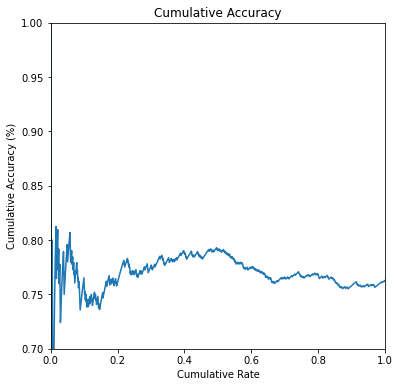

In [17]:
cumulative_acc, cumulative_rate = cumulative_accuracy(y_test, y_pred, dm)

plt.figure(figsize=(6, 6))
plt.plot(cumulative_rate, cumulative_acc)
plt.xlabel("Cumulative Rate")
plt.xlim((0, 1.0))
plt.ylabel("Cumulative Accuracy (%)")
plt.ylim((0.7, 1.0))
plt.title("Cumulative Accuracy")
plt.show()

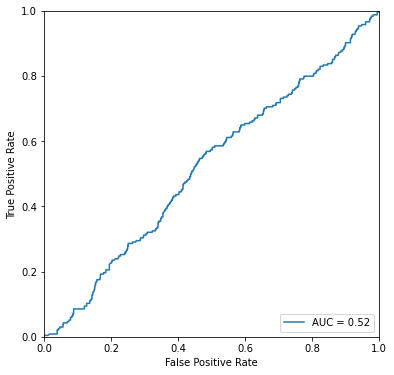

In [18]:
fpr, tpr = roc_ad(y_test, y_pred, dm)
roc_auc = auc(fpr, tpr)

fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot(ax=ax)
ax.set_xlim(0., 1.)
ax.set_ylim(0., 1.)
plt.show()

In [19]:
perm_auc, _ = permutation_auc(y_test, y_pred, dm)
print(perm_auc)

0.47538120719178084


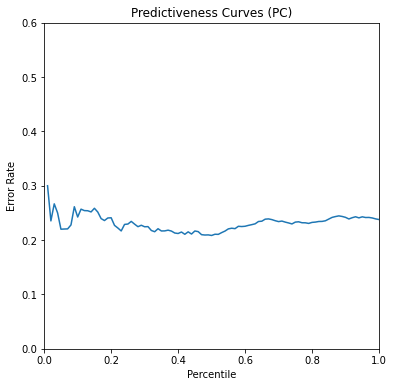

In [20]:
percentile, error_rate = predictiveness_curves(y_test, y_pred, dm)

fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(percentile, error_rate)
ax.set_xlabel("Percentile")
ax.set_xlim(0., 1.)
ax.set_ylabel("Error Rate")
ax.set_ylim(0., 0.6)
ax.set_title("Predictiveness Curves (PC)")
plt.show()